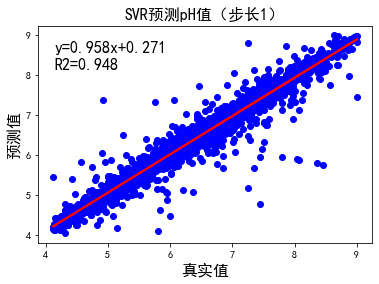

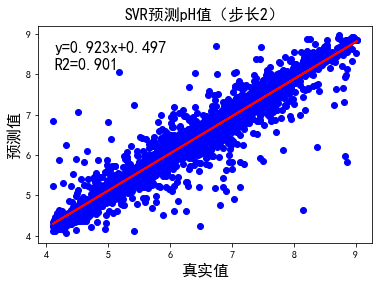

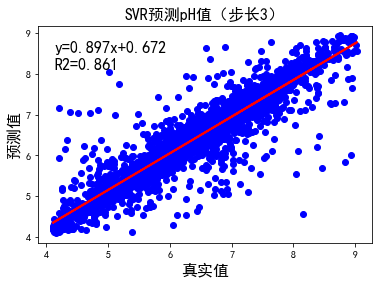

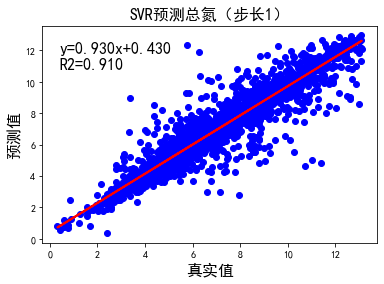

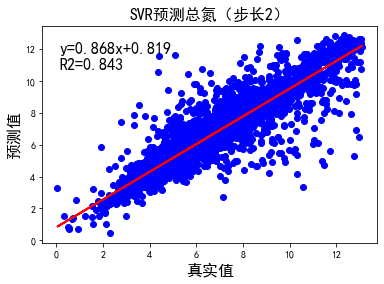

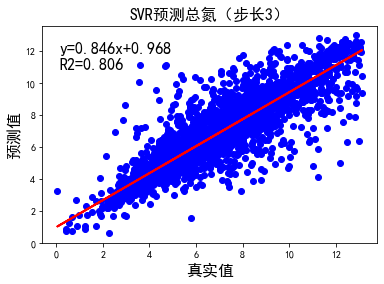

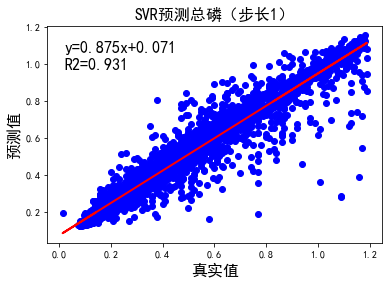

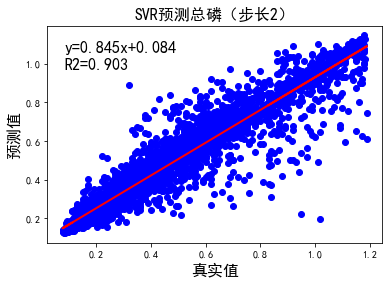

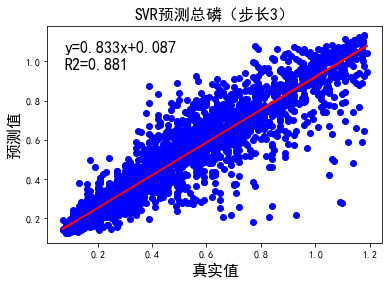

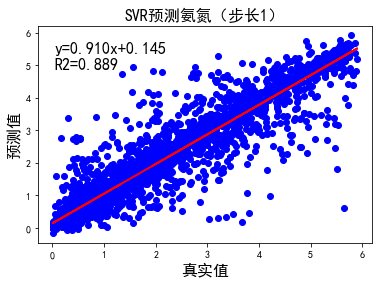

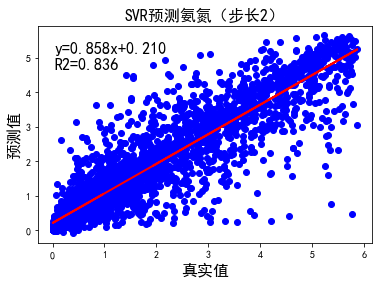

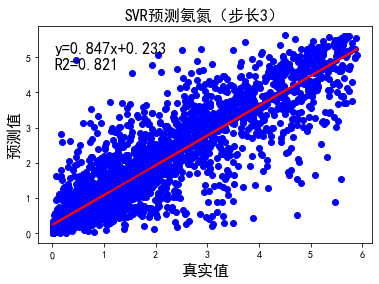

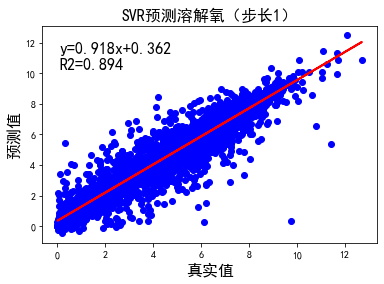

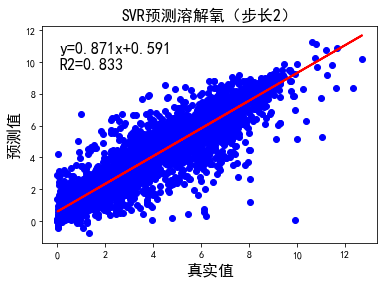

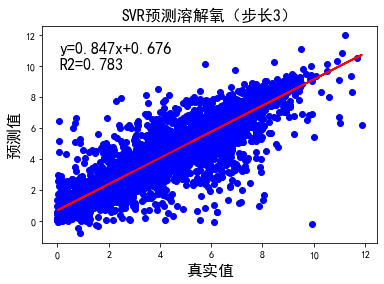

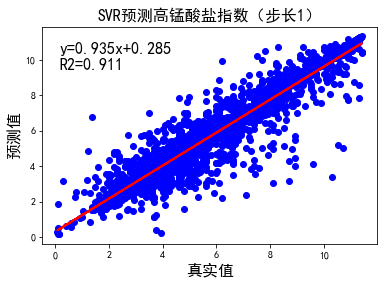

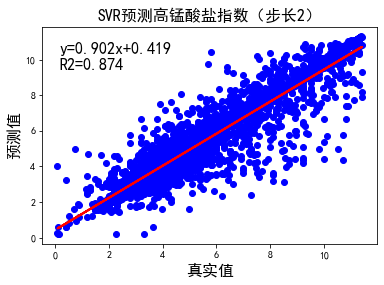

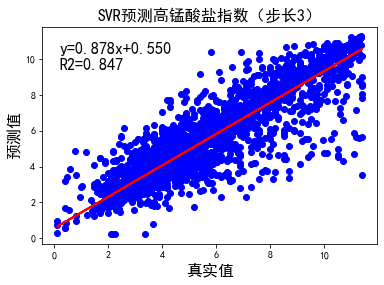

In [61]:
factors = ['pH值', '总氮', '总磷', '氨氮', '水温', '浑浊度', '溶解氧', '电导率', '高锰酸盐指数']

import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

for fac in [0,1,2,3,6,8]:
    for step in range(3):
        y = np.load(f'data/output/y/SVR/SVR_fac{fac}_step{step}.npz')
        # 建立线性回归模型
        regr = linear_model.LinearRegression()
        # 拟合
        y_test = y['y_test'].reshape(-1,1)
        y_pred = y['y_pred'].reshape(-1,1)
        regr.fit(y_test,y_pred) # 注意此处.reshape(-1, 1)，因为X是一维的！

        # 不难得到直线的斜率、截距
        k, b = regr.coef_, regr.intercept_
        r2 = regr.score(y_test,y_pred)

        # 画图
        fig = plt.figure()
        ax = fig.add_subplot()
        # 1.真实的点
        ax.scatter(y_test, y_pred, color='blue')

        # 2.拟合的直线
        ax.plot(y_test, regr.predict(y_test), color='red', linewidth=2)

        plt.rcParams['font.sans-serif']=['SimHei']#显示中文标签
        # plt.rcParams[‘axes.unicode_minus’]=False
        plt.xlabel('真实值',fontsize=16)
        plt.ylabel('预测值',fontsize=16)
        plt.title(f'SVR预测{factors[fac]}（步长{step+1}）',fontsize=16)


        plt.text(0.05,0.8,f'y={k[0][0]:.3f}x+{b[0]:.3f}\nR2={r2:.3f}',
                 fontsize=16,transform=ax.transAxes)
        plt.savefig(f'data/output/figure/SVR/SVR{factors[fac]}_步长{step+1}_回归.png'
                    ,dpi=960)
        plt.show()
    # break
    



In [14]:
import pandas as pd

df = pd.read_csv('water/temp/4.csv')
print(df.columns)
print('min,max,mean,std,skew,kurt')
for col in df.columns[3:12]:
    print(f'{col},{df[col].min():.3f},{df[col].max():.3f},{df[col].mean():.3f}'
          f',{df[col].std():.3f},{df[col].skew():.3f},{df[col].kurt():.3f}')

Index(['index', '监测时间', '站点名称', 'pH值', '总氮', '总磷', '氨氮', '水温', '浑浊度', '溶解氧',
       '电导率', '高锰酸盐指数', 'phFlag', 'TNFlag', 'TPFlag', 'NHFlag', 'temperFlag',
       'turbiFlag', 'doxygenFlag', 'conductFlag', 'permangaFlag'],
      dtype='object')
min,max,mean,std,skew,kurt
pH值,4.111,9.023,6.550,0.957,-0.164,-0.180
总氮,0.540,13.007,6.471,2.361,0.519,-0.144
总磷,0.045,1.172,0.447,0.271,0.815,-0.241
氨氮,0.003,5.963,1.752,1.480,0.949,-0.193
水温,12.042,36.550,26.201,4.808,-0.360,-0.739
浑浊度,0.000,1192.788,20.813,47.653,12.229,222.854
溶解氧,0.005,11.681,4.647,2.437,-0.209,-0.968
电导率,0.000,2639.052,315.000,282.111,2.211,9.733
高锰酸盐指数,0.123,11.167,5.092,2.407,0.863,-0.263
